##### Это финальное задание по курсу «Поиск структуры в данных».

В нем вы попробуете визуализировать данные при помощи PCA и t-SNE и сравните визуально качество этих методов. Также вы попробуете использовать новые признаковые описания для повышения качества классификации объектов.

В качестве данных для этого задания будем использовать данные соревнования Otto Group Product Classification Challenge: https://www.kaggle.com/c/otto-group-product-classification-challenge

Так как данных там может быть слишком много для обработки на домашнем компьютере с помощью t-SNE, то мы сделали их случайную подвыборку и приложили к заданию (файл data.csv).

In [24]:
import matplotlib.pyplot as plt
import sklearn.ensemble
import sklearn.manifold
import sklearn.decomposition
import sklearn.metrics
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import pandas as pd
import seaborn as sns


In [2]:
%matplotlib inline

### Загрузка данных

Загрузите данные из __data.csv__. Положите первые 70% объектов для обучения моделей, а оставшиеся 30% для контроля. Учтите, что первый столбец — это __id__ объекта и его нужно убрать из признаков (потому что сейчас классы объектов отсортированы по __id__). Так как некоторые алгоритмы и метрики считают, что метки классов — это последовательные числа с нуля, то сразу приведите целевую переменную к такому виду. Отрисовку и понижение размерности данных делайте сразу и для обучающей, и для тестовой выборки.

In [7]:
df = pd.read_csv('data.csv')
X = df.drop(['id', 'target'], axis=1)
y = df.loc[:, 'target']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4321)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7000, 93) (3000, 93) (7000,) (3000,)


### Визуализация с помощью PCA

Понизьте размерность данных до 2-ух с помощью метода главных компонент. Нарисуйте полученную выборку, при этом цветом выделите объекты разных классов.

In [16]:
pca = sklearn.decomposition.PCA(n_components=2)
pca_X = pca.fit_transform(X)
pca_X.shape

(10000, 2)

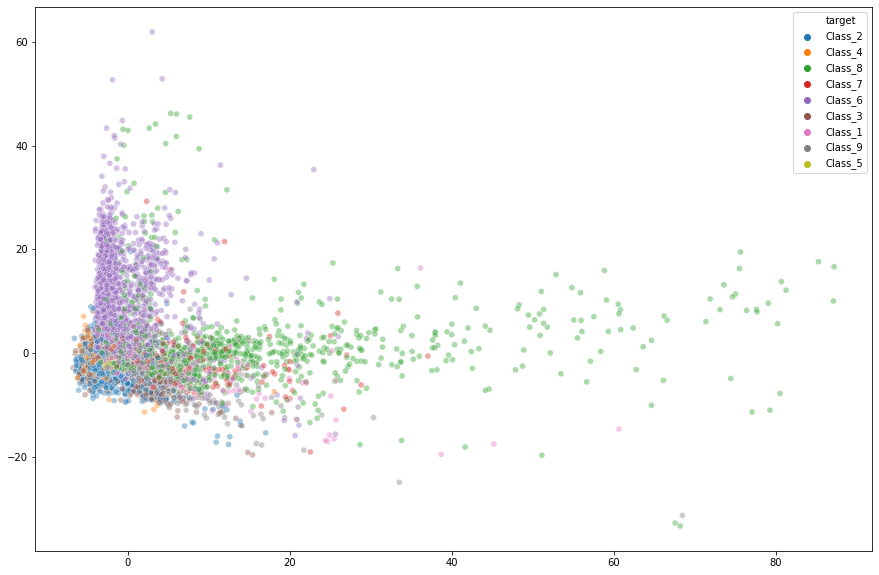

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(pca_X[:, 0], pca_X[:, 1], hue=y, alpha=0.4)
plt.show()

### Визуализация с помощью t-SNE

Теперь понизьте размерность данных до 2-ух с помощью метода t-SNE. В качестве параметров возьмите learning_rate=1000, init="random" и random_state=1234 (последнее — для воспроизводимости результата). Нарисуйте полученную выборку, при этом цветом выделите объекты разных классов. Сравните качественно разделимость классов при понижении размерности с помощью PCA и t-SNE.

In [21]:
tsne = sklearn.manifold.TSNE(learning_rate=1000, init="random", random_state=1234)
tsne_X = tsne.fit_transform(X)

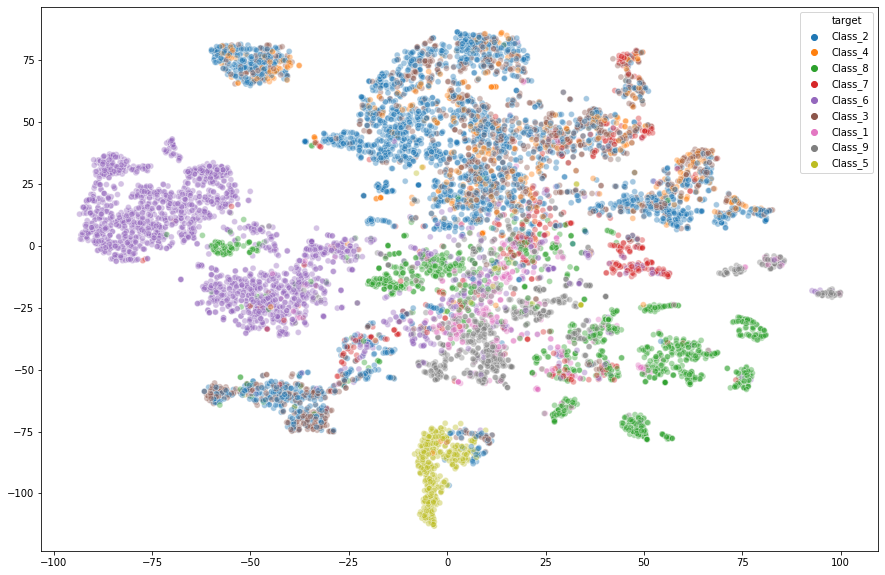

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(tsne_X[:, 0], tsne_X[:, 1], hue=y, alpha=0.4)
plt.show()

### Обучение моделей

Обучите логистическую регрессию (linear_model.LogisticRegression) и случайный лес (ensemble.RandomForestClassifier) из sklearn. В первом случае подберите оптимальный параметр $C$ на отрезке $[10^{-4}, 10^{4}]$ (по степеням $10$ с шагом $1$, начиная с $-4$), а во втором при фиксированном числе деревьев в 50 подберите $max\_depth$ из отрезка $[2, 48]$ с шагом в 2. За целевую метрику качества возьмите мультиклассовый log-loss. В качестве схемы валидации используйте стратифицированную кросс-валидацию по 5-ти фолдам. Какие параметры оказались оптимальными? 

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
linear_clf = GridSearchCV(LogisticRegression(random_state=4321, solver='lbfgs', multi_class='multinomial',
                                            max_iter=100, n_jobs=4),
                          {'C':[10 ** x for x in range(-4, 5)]}, cv=5,
                          scoring='accuracy')

linear_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100,
                                          multi_class='multinomial', n_jobs=4,
                                          penalty='l2', random_state=4321,
                                          solver='lbfgs', tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,
                               10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [50]:
print(linear_clf.best_score_, linear_clf.score(X_test, y_test))

0.743 0.7653333333333333


In [45]:
rf_clf = GridSearchCV(RandomForestClassifier(random_state=4321, n_estimators=50),
                      {'max_depth':[x for x in range(2, 49, 2)]}, cv=5,
                      scoring='accuracy') 
rf_clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              random_state=4321, verbose=0,
                                              warm_start=False),
             iid='wa

In [51]:
rf_clf.best_params_

{'max_depth': 32}

In [46]:
print(rf_clf.best_score_, rf_clf.score(X_test, y_test))

0.7552857142857143 0.7653333333333333


Посчитайте accuracy и log-loss на отложенной выборке для логистической регрессии и случайного леса. Какие они получились? Какой алгоритм лучше?

### Использование PCA для улучшения классификации

Теперь попробуйте использовать PCA для улучшения качества классификации. Добавьте признаки из маломерного пространства (по 2 числа на каждый объект) в обучающую и тестовую выборку. Заново переподберите параметры к логистической регрессии и случайному лесу. Удалось ли таким образом улучшить качество моделей? Почему с теоретической точки зрения добавление признаков из PCA не должно улучшить качество логистической регрессии?

### Использование t-SNE для улучшения классификации

Теперь проделайте тоже самое с признаками из t-SNE. Стало ли лучше (относительно оригинальных признаков)?